@ Arjit Sakhuja

# Introduction

We have a dataset containing the results of an A/B Test conducted by an e-learning platform on their website to test the assumption that segmenting students based on their study time commitment would improve the overall experience and increase the number of students paying for the course at the end of the free trial. As a marketing data analyst we have to analyze the results of the experiment and perform the hypothesis testing to report key findings.  

## Import the important modules

In [3]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Read the dataset

In [9]:
os.chdir(r'E:\Projects\AB_TEST')
data = pd.read_csv('ab_results.csv')
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Here we can see that we have time series data for both control and treatment group. We also have the information about page where users ended up during the test. The column 'converted' tells us whether a user has paid for the subscription after the free trial. This column will help us to calculate conversion rate metric.

## Exploratory Data Analysis

In [10]:
# Number records in the dataset
data.shape[0]

294478

In [11]:
# Number of unique users in the data
data.user_id.nunique()

290584

In [12]:
# Check for null values
data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [14]:
data.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


From the data it is evident that control group lands on old page and treatment group lands on new page. So, the count of control and count of treatment should match the counts of old_page and new_page respectively. So, we will check this case below.

In [15]:
treatment_mismatch = data[(data.group == 'treatment') & (data.landing_page == 'old_page')]
treatment_mismatch.shape[0]

1965

In [16]:
control_mismatch = data[(data.group == 'control') & (data.landing_page == 'new_page')]
control_mismatch.shape[0]

1928

So, we can see that lot of rows have been mismatched. We need to remove these mismatched rows before proceeding further

In [17]:
index1 = treatment_mismatch.index
index2 = control_mismatch.index
index = index1.append(index2)
data_clean = data.drop(index)

In [19]:
# Check it again
data_clean[(data_clean.group == 'treatment') & (data_clean.landing_page == 'old_page')].shape[0]

0

In [20]:
data_clean[(data_clean.group == 'control') & (data_clean.landing_page == 'new_page')].shape[0]

0

So, we checked it again and found no more mismatched rows. So, we are good to go.

In [21]:
# Check for any duplicated values in the user_id column which is supposed have unique values
data_clean[data_clean['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

In [22]:
# Drop the duplicate user_id
data_clean.drop(2893, inplace=True)

Since our data is cleaned now, let's us check the conversion rates for the control and treatment group

In [23]:
control_conversion_rate = data_clean[data_clean['group'] == 'control']['converted'].mean()
control_conversion_rate

0.1203863045004612

In [24]:
treat_conversion_rate = data_clean[data_clean['group'] == 'treatment']['converted'].mean()
treat_conversion_rate

0.11880806551510564

We see that the conversion rates for both groups are almost similar. So, let's check whether control and tretment groups are equally represented in the dataset.

In [25]:
data_clean.landing_page.value_counts(normalize=True)*100

new_page    50.006194
old_page    49.993806
Name: landing_page, dtype: float64

So, yeah they are almost equally represented. This suggests that treatment group is behaving same as control group. To check this, let's perform hypothesis testing.

## Hypothesis Testing

- Null Hypothesis: Pnew - Pold<=0
- Alternate Hypothesis: Pnew - Pold>0

In [26]:
new = data_clean[data_clean['landing_page'] == "new_page"].shape[0]
new

145310

In [27]:
old = data_clean[data_clean['landing_page'] == "old_page"].shape[0]
old

145274

Now let's simulate the experiment for the population

In [28]:
overall_conversion_rate = data_clean.converted.mean()
# Simulate conversion rate for new page
converted_new_page = np.random.choice([0, 1], size=new, p=[(1 - overall_conversion_rate), overall_conversion_rate])

# Simulate conversion rate for old page
converted_old_page = np.random.choice([0, 1], size=old, p=[(1 - overall_conversion_rate), overall_conversion_rate])

converted_new_page.mean() - converted_old_page.mean()


0.0009822314013885891

In [30]:
# Run 20,000 simulations
diffs = []

for i in range(20000):
    converted_new_page = np.random.choice([0, 1], size=new, p=[(1 - overall_conversion_rate), overall_conversion_rate])
    converted_old_page = np.random.choice([0, 1], size=old, p=[(1 - overall_conversion_rate), overall_conversion_rate])
    diffs.append(converted_new_page.mean() - converted_old_page.mean())

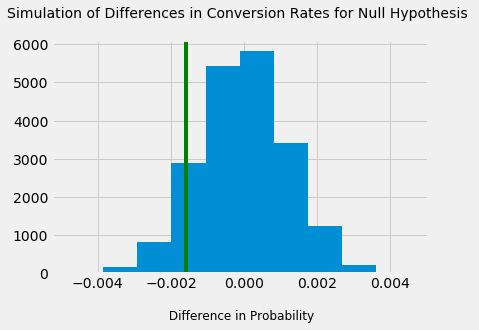

In [33]:
plt.style.use('fivethirtyeight')
diffs = np.asarray(diffs)
plt.hist(diffs)
plt.title("Simulation of Differences in Conversion Rates for Null Hypothesis \n", fontsize=14)
plt.xlabel("\n Difference in Probability", fontsize=12)
plt.axvline(treat_conversion_rate - control_conversion_rate, color='g')

Now we will check that how many vlaues in the above distribution are greater than observed or sample conversion rate difference.

In [34]:
sample_conversion_rate_diff = treat_conversion_rate - control_conversion_rate

(diffs > sample_conversion_rate_diff).mean()

0.9053

## Result of the simulation

The p-value calculated is 0.9053. This is far greater than the typical $\alpha$ level of 0.05. So, we would fail to reject the null and conclude that there is not sufficient evidence to say that that there is a difference between the conversion rates of control and treatment groups

In [35]:
import statsmodels.api as smodel

convert_old = data_clean.query('group == "control" & converted == 1')['converted'].count()
convert_new = data_clean.query('group == "treatment" & converted == 1')['converted'].count()
smodel.stats.proportions_ztest([convert_new, convert_old], [new, old], alternative='larger')


(-1.3109241984234394, 0.9050583127590245)

So, p-values from both z-test and our bootstrapped hypothesis testing are matching. So, we don't have enough evidence to say that that the conversion rates of control and treatment groups are different. So, this means that from the data available we don't have enough evidence to say that segmenting students based on their study time commitment would improve the overall experience and increase the number of students paying for the course at the end of the free trial.